# Practica 1
---
Author: Antoni Payeras, Andreu Sureda <br>
Date: data
---

## Les dades

In [1]:
import pandas as pd

df = pd.read_csv("data.csv", delimiter=r"\s+")
df = df.drop(['0'], axis=1)

In [2]:
df.head()

,catala,angles
0,com,as
1,seva,his
2,que,that
3,ell,he
4,era,was


Primer afegirem la variable de lang a cada un dels idiomes, per poder diferenciar l'idioma de cada paraula

In [3]:
df_cat = df[["catala"]]
df_cat['lang'] = 0
df_cat = df_cat.rename(columns={'catala': 'paraula'})


df_ang = df[["angles"]]
df_ang['lang'] = 1
df_ang = df_ang.rename(columns={'angles': 'paraula'})

Unió dels diferents dataframes de cada llenguatge 

In [4]:
df_final = pd.concat([df_cat, df_ang], ignore_index=True, sort=False)

### Neteja de les dades
#### 1. Eliminació de caracters especials

In [5]:
df_final['paraula'] = df_final['paraula'].str.replace("[\\:.,;_*+^\[\]\(\)/&€%$~\"ªº?¿¡!0-9]", "", regex=True)

df_final = df_final[df_final['paraula'] != '']

#### 2. Eliminació de paraules repetides en el mateix idoma.

La aparició d'una mateixa paraula a un mateix idioma, podria ocasionarmos problemes, ja que podriem estar sobreentrenant per a aquella paraula en concret ?????

In [6]:
df_final = df_final.drop_duplicates(subset=['paraula','lang'])
df_final.shape

(1845, 2)

#### 3. Eliminació de paraules repetides en diferents idomes.

<Perque>

In [7]:
df_final = df_final.drop_duplicates(subset=['paraula'], keep=False)	
df_final.shape

(1725, 2)

## Definició de característiques

* Conté accents
* Conté la lletra "y"
* Conté la lletra "w"
* Conté el diagraf "sh"
* Conté el diagraf "ph"
* Conté la lletra "ç"
* Conté el digraf "l·l"

In [8]:

import re
from Levenshtein import distance as lev

import wordfreq
catalan_common_words = wordfreq.top_n_list('ca', 10000)
english_common_words = wordfreq.top_n_list('en', 10000)

features_columns = ['has_accent','has_y','has_w','has_sh','has_ph','has_ç','has_ll','levenshtein_lang', 'eng_freq', 'cat_freq']

def get_levenshtein_lang(word) : 

    words = df_final['paraula'].tolist()
    lang = df_final['lang'].tolist()
    
    # Eliminar paraula de llista
    index = words.index(word)
    words.pop(index)
    lang.pop(index)

    # Calculate the Levenshtein distances for each row
    distances = [lev(word, _word) for _word in words]
    return  lang[distances.index(min(distances))]


def _features(word) :
    has_accent =  1 if re.search("[àèìòùáéíóú]", word, re.IGNORECASE) else 0
    has_y = 1 if re.search("y", word, re.IGNORECASE) else 0
    has_w = 1 if re.search("w", word, re.IGNORECASE) else 0
    has_sh = 1 if re.search("sh", word, re.IGNORECASE) else 0
    has_ph = 1 if re.search("ph", word, re.IGNORECASE) else 0
    has_ç = 1 if re.search("ç", word, re.IGNORECASE) else 0
    has_ll = 1 if re.search("l·l", word, re.IGNORECASE) else 0
    levenshtein_lang = get_levenshtein_lang(word)
    eng_freq = 1 if word in english_common_words else 0
    cat_freq = 1 if word in catalan_common_words else 0
    return [has_accent,has_y,has_w,has_sh,has_ph,has_ç,has_ll,levenshtein_lang, eng_freq, cat_freq]


features = df_final.apply(lambda row: _features(row['paraula']), axis = 1, )
df_final[features_columns] = features.tolist()
df_final

,paraula,lang,has_accent,has_y,has_w,has_sh,has_ph,has_ç,has_ll,levenshtein_lang,eng_freq,cat_freq
0,com,0,0,0,0,0,0,0,0,0,1,1
1,seva,0,0,0,0,0,0,0,0,0,0,1
2,que,0,0,0,0,0,0,0,0,0,1,1
3,ell,0,0,0,0,0,0,0,0,0,0,1
4,era,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1969,prepare,1,0,0,0,0,0,0,0,0,1,0
1970,salt,1,0,0,0,0,0,0,0,0,1,1
1971,nose,1,0,0,0,0,0,0,0,1,1,0
1973,anger,1,0,0,0,0,0,0,0,1,1,0


### Comprovació de validesa de les característiques escollidess

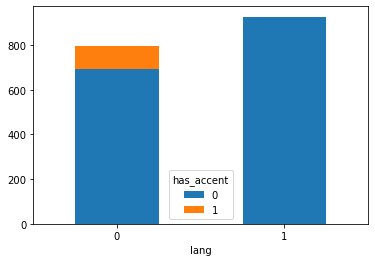

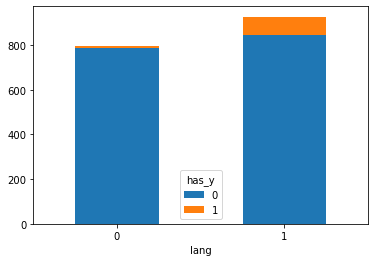

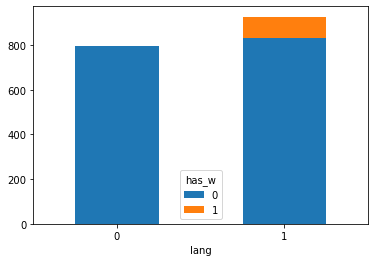

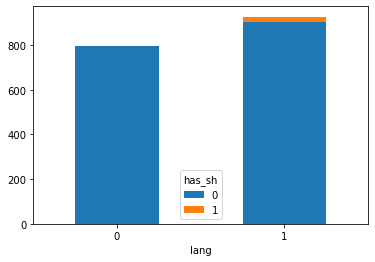

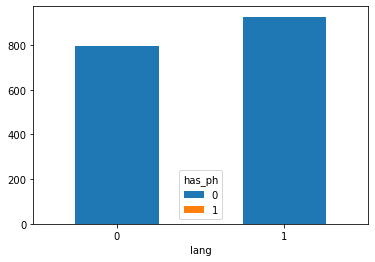

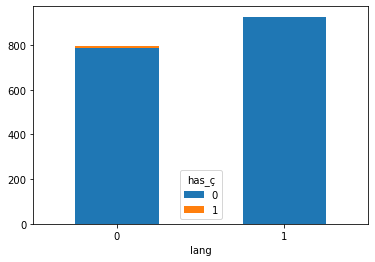

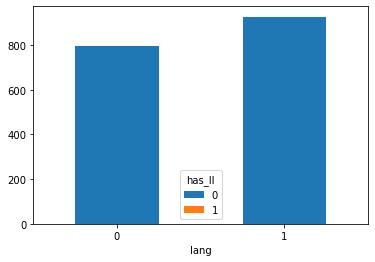

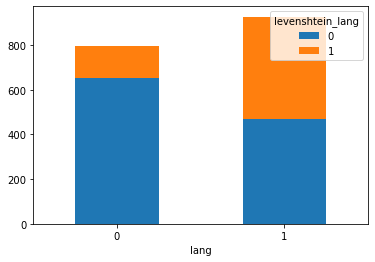

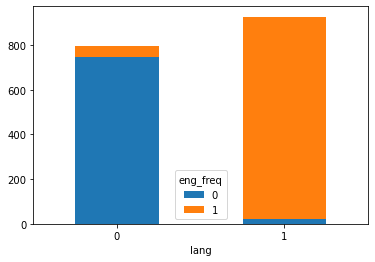

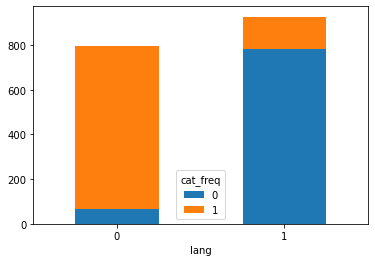

In [9]:
for feature in features_columns:
	ct = pd.crosstab(df_final['lang'], df_final[feature])
	ct.plot.bar(stacked=True, rot=0)

## Classificació

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

y = df_final.pop('lang')
df_final.pop('paraula')
X = df_final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

svm = SVC(C=1000.0, kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))	
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9652173913043478
Precision: 0.9510869565217391
Recall: 0.9831460674157303
